*Import dependencies*

In [1]:
from pyedflib import highlevel
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

*Read data (the first women data)*

In [2]:
path_01 = r'C:\Users\M.Rodriguez\OneDrive\Desktop\ECG Analysis\ecgDataset\r01.edf'

In [3]:
signals_01, signal_headers_01, header_01 = highlevel.read_edf(path_01)

*Extract annotations from header dictionary*

In [4]:
annotations_full = []
for label in header_01['annotations']:
    annotations_full.append(label[0])

annotations_full = np.array(annotations_full)

In [5]:
annotations_full

array([1.83000e-01, 6.51000e-01, 1.11800e+00, 1.58300e+00, 2.04900e+00,
       2.51400e+00, 2.98200e+00, 3.45100e+00, 3.92000e+00, 4.38900e+00,
       4.85700e+00, 5.32700e+00, 5.79600e+00, 6.26300e+00, 6.73200e+00,
       7.20000e+00, 7.66700e+00, 8.13700e+00, 8.60300e+00, 9.06800e+00,
       9.53300e+00, 9.99900e+00, 1.04620e+01, 1.09260e+01, 1.13890e+01,
       1.18480e+01, 1.23090e+01, 1.27670e+01, 1.32240e+01, 1.36800e+01,
       1.41370e+01, 1.45940e+01, 1.50470e+01, 1.55020e+01, 1.59540e+01,
       1.64100e+01, 1.68630e+01, 1.73170e+01, 1.77730e+01, 1.82310e+01,
       1.86880e+01, 1.91430e+01, 1.96000e+01, 2.00580e+01, 2.05170e+01,
       2.09750e+01, 2.14370e+01, 2.19030e+01, 2.23720e+01, 2.28400e+01,
       2.33080e+01, 2.37750e+01, 2.42440e+01, 2.47110e+01, 2.51730e+01,
       2.56350e+01, 2.60960e+01, 2.65580e+01, 2.70210e+01, 2.74860e+01,
       2.79550e+01, 2.84250e+01, 2.88960e+01, 2.93650e+01, 2.98350e+01,
       3.03060e+01, 3.07750e+01, 3.12430e+01, 3.17090e+01, 3.217

*Define **ecg_FeatureExtraction()** function*

```
- Input(s): signal
- Target: find RS peaks of input signal - calculate Dx and Dy for each RS pair
- Return: Dx_pair, Dy_pair, location of R peaks

```

In [7]:
def ecg_FeatureExtraction(input_signal):

    # calculate local maximums and local minimums
    x = input_signal
    x_reversed = -x
    local_max_0, _ = find_peaks(x, distance = 1)
    local_min_0, _ = find_peaks(x_reversed, distance = 1)


    # calculate max min pairs
    pair_storage = []
    for i in local_max_0:
        for j in local_min_0:
            if j > i:
                pair_storage.append((i, j))
                break

    # feature extraction - Dx and Dy
    Dx_pair = []
    Dy_pair = []
    for pair in pair_storage:
        dx = pair[1] - pair[0]
        dy = np.round(x[pair[1]] - x[pair[0]], 2)
        Dx_pair.append(dx)
        Dy_pair.append(dy)

    # convert Dx_array and Dy_array to numpy array an reshape
    Dx_pair = np.array(Dx_pair)
    Dx_pair = Dx_pair.reshape(Dx_pair.shape[0], 1)

    Dy_pair = np.array(Dy_pair)
    Dy_pair = Dy_pair.reshape(Dy_pair.shape[0], 1)

    return Dx_pair, Dy_pair, local_max_0


*Define **ecg_clustering()** function*

```
- Input(s): input_feature, R_peaks_locations, starting sample and ending sample of input signal, extracted annotations
- Target: create KMeans model, fit the model on the input feature, determine fetal and maternal cluster
- Return: maternal_cluster, fetal_cluster, related annotations

```

In [8]:
def ecg_clustering(input_feature, maximum_pairs, start_sample, end_sample, labels):

    from sklearn.cluster import KMeans

    # Apply kmeans on Dy feature
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(input_feature)

    first_cluster_ind = np.where(kmeans.labels_ == 0)
    second_cluster_ind = np.where(kmeans.labels_ == 1)
    third_cluster_ind = np.where(kmeans.labels_ == 2)

    first_cluster = maximum_pairs[first_cluster_ind[0]] + start_sample
    second_cluster = maximum_pairs[second_cluster_ind[0]] + start_sample
    third_cluster = maximum_pairs[third_cluster_ind[0]] + start_sample

    cluster_list = [first_cluster, second_cluster, third_cluster]
    cluster_len_list = np.array([len(first_cluster), len(second_cluster), len(third_cluster)])

    condition = (labels > start_sample / 1000) & (labels < end_sample / 1000)
    annotations = labels[np.where(condition)]

    difference = np.abs(cluster_len_list - len(annotations))
    difference_sorted = np.sort(difference)
    fetal_cluster = cluster_list[np.where(difference == difference_sorted[0])[0][0]]
    maternal_cluster = cluster_list[np.where(difference == difference_sorted[1])[0][0]]
    
    return maternal_cluster, fetal_cluster, annotations
        

*Define **visualize_results()** function*

```
- Input(s): input_signal, R_peaks_locations, starting sample and ending sample of input signal, location of maternal and fetal cluster R peaks
- Target: create subplots - plot three signal, the first is fetal ECG, the second is Abdominal ECG and the third is AECG with detected R peaks
- Return: no return - just visualization

```

In [9]:
def visualize_results(input_signal, start_sample, end_sample, maternal_cluster, fetal_cluster):

    _, ax = plt.subplots(3, 1, figsize = (10, 12))

    ax[0].plot(signals_01[0, start_sample:end_sample])
    ax[0].set_title('Fetal ECG')

    ax[1].plot(signals_01[1, start_sample:end_sample])
    ax[1].set_title('Abdominal Maternal ECG')

    ax[2].plot(input_signal)
    ax[2].plot(maternal_cluster - start_sample, input_signal[maternal_cluster - start_sample], ".", color = 'red')
    ax[2].plot(fetal_cluster - start_sample, input_signal[fetal_cluster - start_sample], ".", color = 'green')
    ax[2].legend(['AECG', 'Maternal QRS', 'Fetal QRS'])

    plt.show()
    

*Define **calc_score()** function*

```
- Input(s): fetal cluster as target cluster, annotations to compare the output of the KMeans model with real labels (R peak locations of fetal)
- Target: calculate false_negative, false_possitive, true_possitive, precision, recall and F1 score of the model
- Additional notes: FN occurs when FQRS overlap with MQRS, FP occurs when we have noise with same amplitude of FQRS
- Return: a dictionary that contains FN, FP, TP, precision, recall and F1 score

```

In [10]:
def calc_score(target_cluster, annotations):

    output_seconds = target_cluster / 1000

    # go for calculating FP, FN, TP, Precision, Recall and F1-Score
    FP = 0
    FN = 0
    TP = 0

    for label in annotations:
        counter = 0
        for output in output_seconds: 
            if abs(label - output) < 0.01:
                counter += 1
                TP += 1

        if counter == 0:
            FN += 1
        
    for output in output_seconds:
        counter = 0
        for label in annotations:
            if abs(label - output) < 0.01:
                counter += 1
        if counter == 0:
            FP += 1


    # calculate precision and recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    # print('precision: ', precision)
    # print('recall', recall)

    # calculate F1-Score
    F1 = 2 / (1 / precision + 1 / recall)
    # print('f1', F1)

    storage_dict = {
        'FN' : FN,
        'FP' : FP,
        'TP' : TP,
        'precision' : precision,
        'recall' : recall,
        'F1-score' : F1
    }

    return storage_dict

### *Work with Frequency Domain (Filtering)*

*Calculating DFT of main signal and the frequency interval*

In [12]:
dft = np.fft.fft(signals_01[1])
frequency = np.linspace(0, 1000, len(dft))

*Plot the magnitude of DFT in the interval of [0, 200] Hz*

Text(0.5, 1.0, 'Magnitude of DFT')

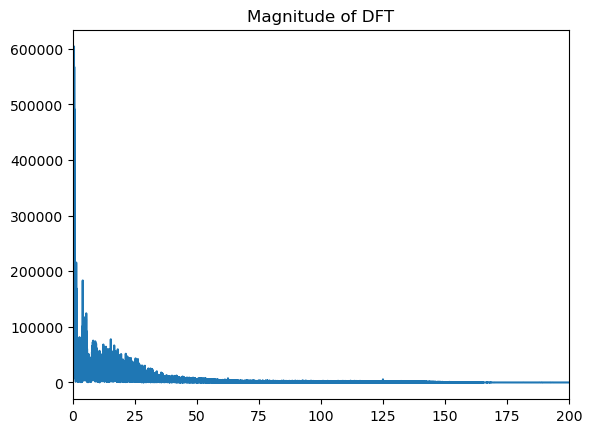

In [13]:
plt.plot(frequency, np.abs(dft))
plt.xlim([0, 200])
plt.title('Magnitude of DFT')

*Define **lowPassFiltering()** function*

```
- Input(s): input_signal which we want to apply filtering on, sampling frequency (1000 in our case), cutoff frequency based on the graph above
- Target: calculate low pass filter and apply on the input_signal
- Return: filtered signal

```

In [14]:
def lowPassFiltering(input_signal, sampling_freq, cutoff_freq):

    dft = np.fft.fft(input_signal)
    frequency = np.linspace(0, sampling_freq, len(dft))

    lpf_condition = (frequency > cutoff_freq) & (frequency < sampling_freq - cutoff_freq)
    dft_filtered_low = np.where(lpf_condition, 0, dft)
    filtered_signal = np.real(np.fft.ifft(dft_filtered_low))

    return  filtered_signal

*Define **highPassFiltering()** function*

```
- Input(s): input_signal which we want to apply filtering on, sampling frequency (1000 in our case), cutoff frequency (user defined)
- Target: calculate high pass filter and apply on the input_signal
- Return: filtered signal

```

In [15]:
def highPassFiltering(input_signal, sampling_freq, cutoff_freq):

    dft = np.fft.fft(input_signal)
    frequency = np.linspace(0, sampling_freq, len(dft))

    lpf_condition = (frequency > cutoff_freq) & (frequency < sampling_freq - cutoff_freq)
    dft_filtered_low = np.where(lpf_condition, dft, 0)
    filtered_signal = np.real(np.fft.ifft(dft_filtered_low))

    return  filtered_signal

*Apply low pass filter with cutoff frequency of 200 on the main signal*

In [16]:
signal_filtered_low = lowPassFiltering(signals_01[1], sampling_freq = 1000, cutoff_freq = 200)

*Plot the main signal anf filtered signal*

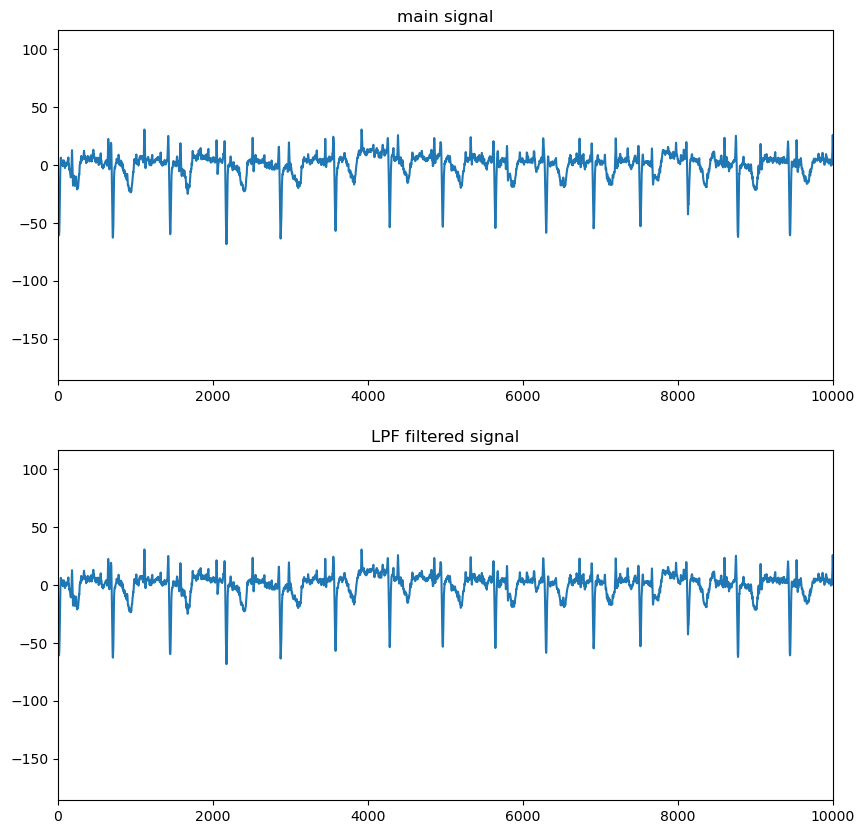

In [17]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

ax[0].plot(signals_01[1])
ax[0].set_xlim([0, 10000])
ax[0].set_title('main signal')

ax[1].plot(signal_filtered_low)
ax[1].set_xlim([0, 10000])
ax[1].set_title('LPF filtered signal')
plt.show()

*Apply high pass filter with cutoff frequency of 1 on the low pass filtered signal*

In [22]:
signal_filtered_high_02 = highPassFiltering(signal_filtered_low, sampling_freq = 1000, cutoff_freq = 1) 

------------------

*Applying clustering algorithm to whole signal, to determine fetal cluster and go to analyse samples*

In [39]:
window_size = 300
signal_batch = len(signal_filtered_high_02) // (window_size * 1000)
signal_storage = np.split(signal_filtered_high_02, signal_batch)

In [97]:
for i in range(len(signal_storage)):

    signal = signal_storage[i]
    start_sample = i * window_size * 1000
    end_sample = (i + 1) * window_size * 1000
    
    Dx_pair, Dy_pair, local_max_0 = ecg_FeatureExtraction(signal)
    maternal_cluster, fetal_cluster, annotations = ecg_clustering(Dy_pair, local_max_0, start_sample, end_sample, annotations_full)

    rr_intervals = np.diff(fetal_cluster)
    
    results = calc_score(fetal_cluster, annotations)

    print(results)
    
    print(fetal_cluster)
    print(rr_intervals)
    print('--------------------------')

{'FN': 51, 'FP': 24, 'TP': 593, 'precision': 0.9611021069692058, 'recall': 0.9208074534161491, 'F1-score': 0.9405233941316417}
[   181    649   1115   1580   2046   2512   2980   3449   3918   4387
   4855   5325   5794   6730   7197   7664   8600   9065   9530   9997
  10459  11386  11846  12765  13677  14135  14263  14591  15045  15499
  15953  16408  16861  17315  17770  18228  18685  19140  19597  20062
  20515  20972  21317  21436  21901  22369  22838  23304  23773  24241
  24707  25172  25633  26555  27019  27484  27953  28893  29363  29833
  29997  30305  30773  31240  31707  32172  32637  33100  33562  34024
  34458  34484  34951  35413  36041  36341  36806  37156  37272  37741
  38676  39144  39615  40083  41022  41188  41490  41958  42428  42897
  43128  43343  43367  43840  44314  44788  45260  45734  46077  46207
  46679  47149  47620  48092  48563  49033  49503  49972  50440  50907
  51375  51844  52309  52776  53243  53711  54178  55105  55566  56025
  56488  57406  57870

### *Post Processing of False Negatives*

**CASE 1:** *in this case consecutive samples that have large distance detecteed and then calculate the lost sample that locate in the middle of  them.*

*Calculate those samples with large distance between*

In [98]:
index_short_dis = np.where(rr_intervals > 800)[0]
print(index_short_dis)

[ 12  15  20  22  23  52  56  79  83 116 120 128 169 173 179 203 205 210
 212 240 297 301 305 309 313 317 324 337 357 386 401 411 427 439 441 459
 469 485 492 503 505 516 547 554 564 571]


*Calculate lost samples and locate them in suitable indices.*

In [93]:
counter = 0
for i in index_short_dis:
    i = i + counter
    print(i)
    print(rr_intervals)
    print(fetal_cluster)
    threshold = int(np.mean(rr_intervals[i - 5: i]))

    print(threshold)

    new_r_peak = fetal_cluster[i] + threshold

    print(new_r_peak)

    fetal_cluster = np.insert(fetal_cluster, i + 1, new_r_peak)

    rr_intervals = np.diff(fetal_cluster)
    counter += 1

12
[ 468  466  465  466  466  468  469  469  469  468  470  469  936  467
  467  936  465  465  467  462  927  460  919  912  458  128  328  454
  454  454  455  453  454  455  458  457  455  457  465  453  457  345
  119  465  468  469  466  469  468  466  465  461  922  464  465  469
  940  470  470  164  308  468  467  467  465  465  463  462  462  434
   26  467  462  628  300  465  350  116  469  935  468  471  468  939
  166  302  468  470  469  231  215   24  473  474  474  472  474  343
  130  472  470  471  472  471  470  470  469  468  467  468  469  465
  467  467  468  467  927  461  459  463  918  464  461  466  244  222
  468  468  934  471  469  463  467  464  462  464  469  465  467  464
  468  468  469  472  473  478  479  483  480  480  478  480  478  475
  477  473  477  472  476  473  476  469  467  471  467  467  468  475
  472  944  468  466  465  933  464  465  467  473  476  959  478  472
  483  481  593  366  486  482  400   88  483  479  480  483  481  478
  4

In [94]:
fetal_cluster

array([   181,    649,   1115,   1580,   2046,   2512,   2980,   3449,
         3918,   4387,   4855,   5325,   5794,   6263,   6730,   7197,
         7664,   8131,   8600,   9065,   9530,   9997,  10459,  10924,
        11386,  11846,  12309,  12765,  13226,  13677,  14135,  14263,
        14591,  15045,  15499,  15953,  16408,  16861,  17315,  17770,
        18228,  18685,  19140,  19597,  20062,  20515,  20972,  21317,
        21436,  21901,  22369,  22838,  23304,  23773,  24241,  24707,
        25172,  25633,  26098,  26555,  27019,  27484,  27953,  28417,
        28893,  29363,  29833,  29997,  30305,  30773,  31240,  31707,
        32172,  32637,  33100,  33562,  34024,  34458,  34484,  34951,
        35413,  36041,  36341,  36806,  37156,  37272,  37741,  38081,
        38676,  39144,  39615,  40083,  40551,  41022,  41188,  41490,
        41958,  42428,  42897,  43128,  43343,  43367,  43840,  44314,
        44788,  45260,  45734,  46077,  46207,  46679,  47149,  47620,
      

*Calculate the score of new fetal cluster.*

In [95]:
results = calc_score(fetal_cluster, annotations)

In [96]:
print(results)

{'FN': 14, 'FP': 33, 'TP': 630, 'precision': 0.9502262443438914, 'recall': 0.9782608695652174, 'F1-score': 0.9640397857689366}


> #### *As we can see in the above results, the numbers of False Negatives that was 51, is now 14* 